In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error
import seaborn as sns
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import imageio
import os
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import cross_val_score, KFold

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!cp /content/drive/My\ Drive/ey/data_science.zip .
!unzip data_science.zip

Archive:  data_science.zip
  inflating: sales.csv               
  inflating: shops.csv               
  inflating: item_categories.csv     
  inflating: items.csv               


In [19]:
transactions    = pd.read_csv('sales.csv')
items           = pd.read_csv('items.csv')
item_categories = pd.read_csv('item_categories.csv')
shops           = pd.read_csv('shops.csv')

In [110]:
transactions.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0
5,2013-01-10,0,25,2564,349.00,1.0


In [79]:
test = transactions.groupby(['shop_id', 'item_id']).size().reset_index(name='Freq')
test.loc[:,'date_block_num'] = pd.Series([34]*len(test))
test

,shop_id,item_id,Freq,date_block_num
0,0,30,9,34
1,0,31,7,34
2,0,32,11,34
3,0,33,6,34
4,0,35,12,34
...,...,...,...,...
423454,59,22154,1,34
423455,59,22155,1,34
423456,59,22162,16,34
423457,59,22164,6,34


# **Famous Shops**

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


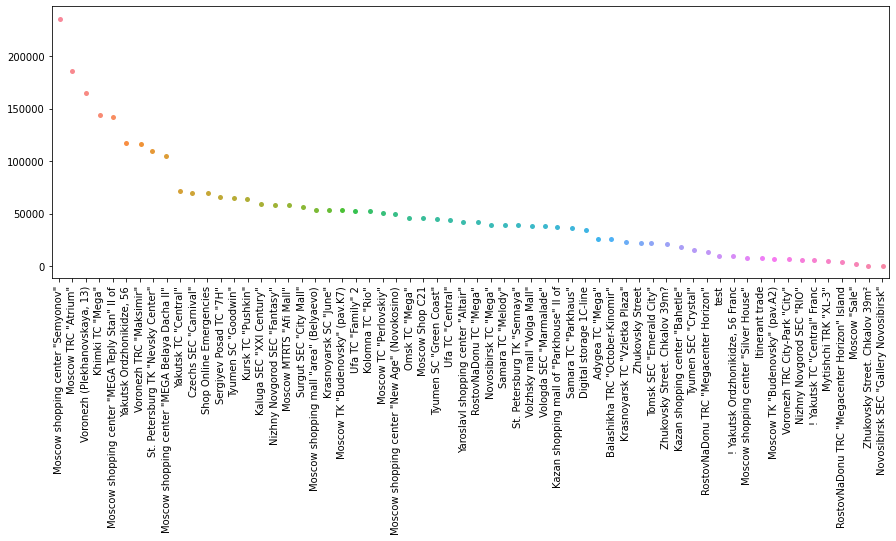

In [22]:
shops.columns = ['system_id','shop_name','shop_id','active_flag']
transactions_vis = pd.merge(transactions, shops, on = 'shop_id', how = 'inner')
Z = dict(transactions_vis['shop_name'].value_counts())
fig, ax = plt.subplots(1, figsize=(15, 5))
sns.stripplot(list(Z.keys()), list(Z.values()), ax = ax)
plt.xticks(rotation = 90)
plt.show()

# **Newly Introduce items Per month**

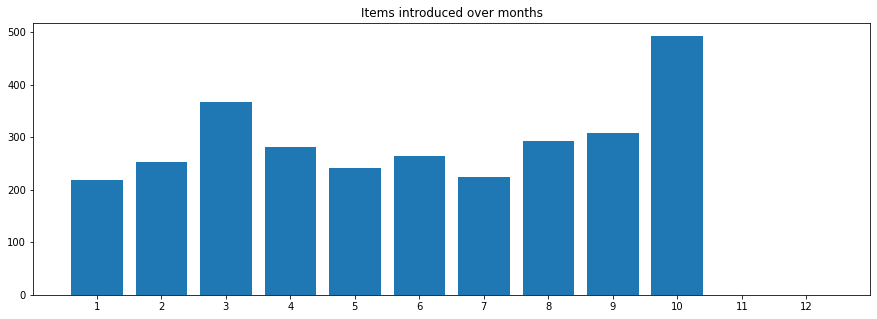

In [23]:
df = transactions[transactions.date_block_num >= 12]
months = np.sort(df.date_block_num.unique())
new_items_introduced = [0] * 12
for i in range(12, len(months)):
    new_items_introduced[i%12] += len(np.setdiff1d(df[df.date_block_num == months[i]]['item_id'].unique(), df[df.date_block_num < months[i]]['item_id'].unique()))
   
plt.figure(figsize = (15, 5))
plt.bar(np.arange(1,13), new_items_introduced)
plt.title('Items introduced over months')
plt.xticks(np.arange(1,13))
plt.show()

# **Plot the feature distributions**

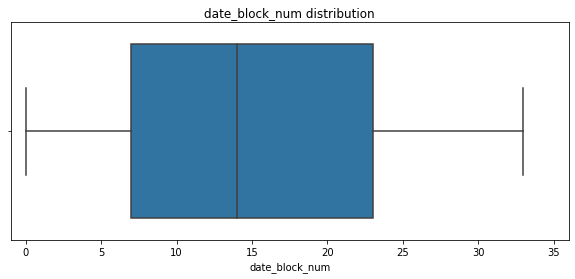

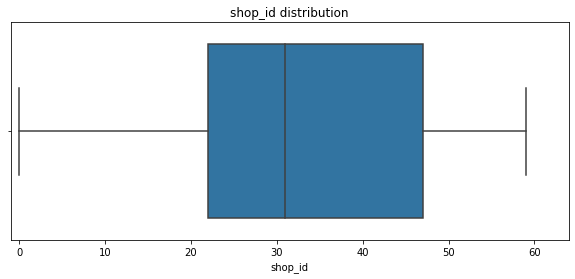

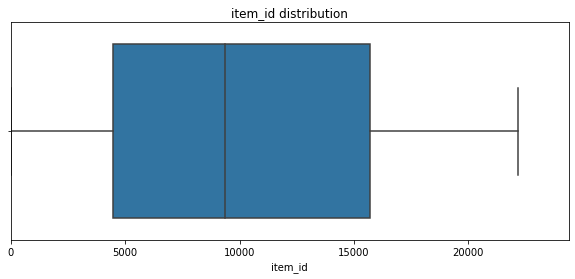

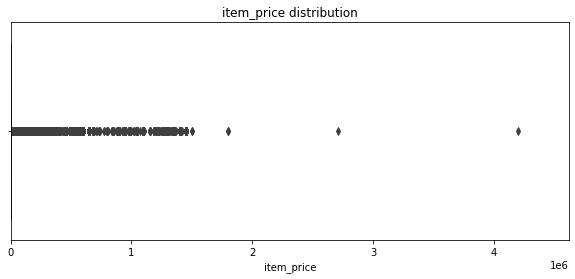

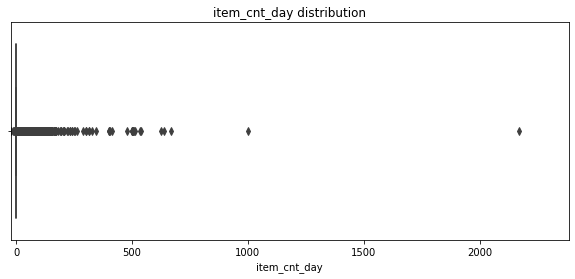

In [24]:
def box_plot(df,f):
    plt.figure(figsize=(10,4))
    plt.title(f+' distribution')
    x_min = int(df[f].min() - (abs(df[f].min())*0.1))
    x_max = int(df[f].max() + (abs(df[f].max())*0.1))
    if x_min==0:
        x_min = -1
    if x_max==0:
        x_max = 1
    plt.xlim(x_min,x_max)
    sns.boxplot(x=df[f])

plot_features = [x for x in transactions.columns.values if transactions[x].dtype != 'object']
for f in plot_features:
    box_plot(transactions,f)

# **Outliers removal**

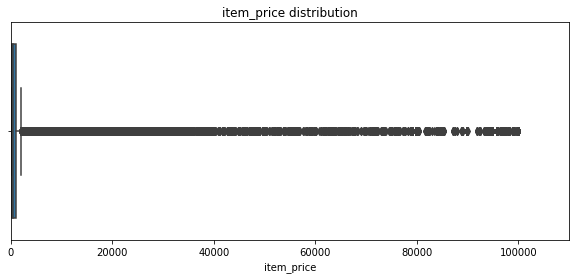

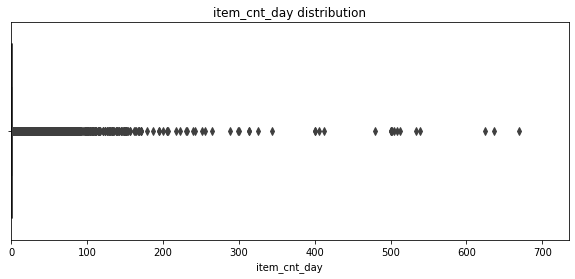

In [25]:
transactions = transactions[(transactions['item_price']<100000) & (transactions['item_price']>=0)]
transactions = transactions[(transactions['item_cnt_day']<1000) & (transactions['item_cnt_day']>=0)]

# distribution after outliers removal
plot_features = ['item_price','item_cnt_day']
for f in plot_features:
    box_plot(transactions,f)

# **Cheking null**

In [26]:
transactions['date'] = pd.to_datetime(transactions['date'], dayfirst=True)
print(transactions['date'].min())
print(transactions['date'].max())
transactions.isnull().sum()

2013-01-01 00:00:00
2015-10-31 00:00:00


date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [27]:
transactions.head() 

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0
5,2013-01-10,0,25,2564,349.00,1.0


In [28]:
from itertools import product
index_cols = ['shop_id', 'item_id', 'date_block_num']

In [29]:
grid = []
for block_num in transactions['date_block_num'].unique():
    cur_shops = transactions.loc[transactions['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = transactions.loc[transactions['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])), dtype='int32'))
grid = pd.DataFrame(np.vstack(grid), columns = index_cols, dtype=np.int32)

In [30]:
mean_transactions = transactions.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day':'sum','item_price':np.mean}).reset_index()
mean_transactions = pd.merge(grid,mean_transactions,on=['date_block_num', 'shop_id', 'item_id'],how='left').fillna(0)
mean_transactions = pd.merge(mean_transactions, items, on='item_id',how='left')
mean_transactions.head()

,shop_id,item_id,date_block_num,item_cnt_day,item_price,item_name,category
0,59,22154,0,1.0,999.0,Scene 2012 (BD),37
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58
2,59,2554,0,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58
3,59,2555,0,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56
4,59,2564,0,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59


# **DecisionTreeClassifier**

In [59]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

model_DTC = tree.DecisionTreeClassifier(criterion='gini') 

cols = ['shop_id','date_block_num','item_id']
monthly_sales.astype('int64')
X = monthly_sales[cols] # Predictor columns
y = monthly_sales.item_cnt_day  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [60]:
clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [61]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

val_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Val RMSE: %f" % (val_rmse))

Accuracy: 0.5428413649387861
Val RMSE: 7.096344


In [65]:
del clf

# **Xgboost**

In [84]:
DM_train = xgb.DMatrix(data=X_train, label=y_train)
DM_test =  xgb.DMatrix(data=X_test, label= y_test)


param = {'max_depth':10, 
         'subsample':1,
         'min_child_weight':0.5,
         'eta':0.3, 
         'num_round':1000, 
         'seed':1,
         'silent':0,
         'eval_metric':'rmse'} # random parameters

bst = xgb.train(param, dtrain=DM_train)

In [57]:
preds = bst.predict(DM_test)
# Compute and print the RMSE
rmse = np.sqrt(mean_squared_error(y_test,preds))
print("RMSE: %f" % (rmse))

RMSE: 5.195221


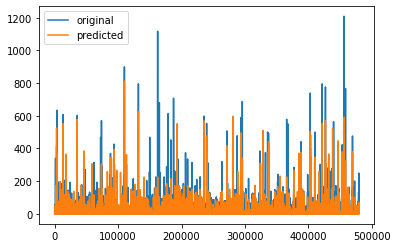

In [64]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, preds, label="predicted")
plt.legend()
plt.show()

In [86]:
X = test[cols]
xgbpredict = xgb.DMatrix(X)
preds = bst.predict(xgbpredict)

In [90]:
test.loc[:,'prediction_cnt'] = preds

In [109]:
test.astype('int64')

max_ = test.loc[test['prediction_cnt'].idxmax()]
print(max_,"---highest selling product of next month")
print("----------------"+"\n")


for region, df_region in test.groupby('shop_id'):
    print("Shop: ",region )
    max_ = df_region.loc[df_region['prediction_cnt'].idxmax()]
    print(max_)
    print("----------------"+"\n")


shop_id             12.000000
item_id           9248.000000
Freq                60.000000
date_block_num      34.000000
prediction_cnt     849.892639
Name: 63354, dtype: float64 ---highest selling prodcu of next month
----------------

Shop:  0
shop_id               0.000000
item_id           16623.000000
Freq                 18.000000
date_block_num       34.000000
prediction_cnt       11.476667
Name: 2657, dtype: float64
----------------

Shop:  1
shop_id              1.000000
item_id           9216.000000
Freq                 1.000000
date_block_num      34.000000
prediction_cnt       7.286719
Name: 4490, dtype: float64
----------------

Shop:  2
shop_id              2.000000
item_id           9241.000000
Freq                 1.000000
date_block_num      34.000000
prediction_cnt     162.371109
Name: 8325, dtype: float64
----------------

Shop:  3
shop_id              3.000000
item_id           9241.000000
Freq                12.000000
date_block_num      34.000000
prediction_cnt    